In [143]:
import matplotlib.pyplot as plt
from plotly import tools
from mpl_toolkits.mplot3d import Axes3D
import collections
import numpy as np
import plotly as py
import plotly.graph_objs as go
import datetime
from sklearn.model_selection import train_test_split
import pandas as pd
from joblib import load, dump
from scipy import signal
from numpy.linalg import norm, inv
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import backend as K
from IPython.lib import backgroundjobs as bg
jobs = bg.BackgroundJobManager()
py.offline.init_notebook_mode(connected = True)


In [2]:
def FindPhoneDataIntervals(phoneData):
    intervals = []
    
    currentInterval = []
    currentCoordinate = None
    multiKeypressInterval = []
    multiKeypressCoordinate = None
    for datum in phoneData:
        if datum['eventID'] == 0:
            currentInterval.append(datum['timeStamp'])
            currentCoordinate = datum['x']
        
        if datum['eventID'] == 5:
            if currentInterval == []:
                currentInterval.append(datum['timeStamp'])
            else:
                multiKeypressInterval.append(datum['timeStamp'])
                multiKeypressCoordinate = datum['x']
        
        if len(currentInterval) == 0 and len(multiKeypressInterval) == 0:
            print("Failed to match a key release with the following time stamp: {}".format(datum['timeStamp']))
            continue
            
        if datum['eventID'] == 1:
            currentInterval.append(datum['timeStamp'])
            intervals.append(currentInterval)
            currentInterval = []
            multiKeypressInterval = []
                
        if datum['eventID'] == 6:
            if len(currentInterval) == 1 and len(multiKeypressInterval) == 1:
                if abs(datum['x'] - multiKeypressCoordinate) < abs(datum['x'] - currentCoordinate):
                    multiKeypressInterval.append(datum['timeStamp'])
                    intervals.append(multiKeypressInterval)
                else:
                    currentInterval.append(datum['timeStamp'])
                    intervals.append(currentInterval)
                    currentInterval = multiKeypressInterval
                    
                multiKeypressInterval = []
                
            else:
                currentInterval.append(datum['timeStamp'])
                intervals.append(currentInterval)
                currentInterval = []
                
            
            
    return intervals

def getKeypressLabels(thumbData, phoneData):
    keypressLabels = np.zeros(len(thumbData))
    
    phoneDataIntervals = FindPhoneDataIntervals(phoneData)
    intervalIndex = 0
    currentInterval = phoneDataIntervals[intervalIndex]
    
    for thumbDataIndex, thumbDatum in thumbData.iterrows():
        while currentInterval[1] < thumbDatum['timeStamp']:
            intervalIndex += 1
            
            if intervalIndex > len(phoneDataIntervals):
                return keypressLabels
            
            currentInterval = phoneDataIntervals[intervalIndex]
        
        if thumbDatum['timeStamp'] >= currentInterval[0] and thumbDatum['timeStamp'] <= currentInterval[1]:
            keypressLabels[thumbDataIndex] = 1
            
        elif thumbDatum['timeStamp'] < currentInterval[0]:
            continue
            
    return keypressLabels
            
            

In [3]:
keyboardDataFileName = 'keyboard_data.txt'
g_thumbKeyboardPositions = collections.defaultdict(np.array)
with open(keyboardDataFileName, 'r') as file:
    for line in file:
        posX, posY, letter = line.split()
        g_thumbKeyboardPositions[letter] = np.array([float(posX), float(posY)])

g_thumbKeyboardPositions[" "] = np.array([900., 850.]) 

def gridCoordinateSearch(coordinate, thumbKeyboardPositions):
    leadingLetters = ["q", "a","z", " "]
    rows = ["qwertyuiop", "asdfghjkl", "zxcvbnm", " "]
    closestRowIndex = min([ind for ind in range(len(leadingLetters))], key = lambda ind: abs(coordinate[1] - thumbKeyboardPositions[leadingLetters[ind]][1]))
    
    closestLetter = min([letter for letter in rows[closestRowIndex]], key = lambda letter: abs(coordinate[0] - thumbKeyboardPositions[letter][0]))
    
    return closestLetter

gridCoordinateSearch(np.array([000.,900.]), g_thumbKeyboardPositions)
        
    

' '

In [4]:
markersDataFileName = "2019-03-13-15-18-38-752_markers_left.txt"
phoneDataFileName = "2019-03-13-15-18-38-747_left.txt"

In [5]:
markersData = []
phoneData = []

with open(phoneDataFileName, 'r') as file:
    itemHeaders = ["timeStamp", "logIndex", "keyboardID", "eventID", "x", "y"]
    for line in file:
        logEntry = line.split()
        if len(logEntry) == len(itemHeaders):
            phoneDatum = {itemName: data for itemName, data in zip(itemHeaders, logEntry)}
            phoneDatum["timeStamp"] = datetime.datetime.strptime(phoneDatum["timeStamp"], "%Y-%m-%d-%H-%M-%S-%f")
            phoneDatum["eventID"] = int(phoneDatum["eventID"])
            phoneDatum["logIndex"] = int(phoneDatum["logIndex"])
            phoneDatum["x"] = float(phoneDatum["x"])
            phoneDatum["y"] = float(phoneDatum["y"])          
            phoneData.append(phoneDatum)
        
with open(markersDataFileName, 'r') as file:
    itemHeaders = ["timeStamp", "logIndex", "markerID", "x", "y", "z"]
    for line in file:
        if logEntry != "":
            logEntry = line.split()
            if len(logEntry) == len(itemHeaders):
                timeStamp = datetime.datetime.strptime(logEntry[0], "%Y-%m-%d-%H-%M-%S-%f")
                if timeStamp >= phoneData[0]['timeStamp'] and timeStamp <= phoneData[-1]['timeStamp']:
                    markersDatum = {itemName: data for itemName, data in zip(itemHeaders, logEntry)}
                    markersDatum["timeStamp"] = timeStamp
                    markersDatum["markerID"] = int(markersDatum["markerID"])
                    markersDatum["logIndex"] = int(markersDatum["logIndex"])
                    markersDatum["x"] = float(markersDatum["x"])
                    markersDatum["y"] = float(markersDatum["y"])
                    markersDatum['z'] = float(markersDatum['z'])
                    markersData.append(markersDatum)

markersDataDictByID = collections.defaultdict(list)

for markersDatum in markersData:
    markersDataDictByID[markersDatum['markerID']].append(markersDatum)

In [7]:
plotData = collections.defaultdict(list)
markersData.sort(key = lambda datum:datum['timeStamp'])
for data in markersData[:20000]:
    plotData[data["markerID"]].append([float(data['x']), float(data['y']), float(data['z'])])

traces = []
for markerID, trajectory in plotData.items():
    trajectory = np.array(trajectory)
    trace = go.Scatter3d(
        x=trajectory[:,0],
        y=trajectory[:,1],
        z=trajectory[:,2],
        mode='lines',
        name = markerID
    )
    traces.append(trace)
    
fig = go.Figure(data = traces)

py.offline.plot(fig, filename = "left hand trajectory")

'file://C:\\Users\\Dave Lei\\Part IIB project\\Data logging\\left hand trajectory.html'

In [6]:
tipMarkerIDs = [53641]
middleMarkerIDs = [53639]
endMarkerIDs = [53640]


topMarkerLeftID = 50090
topMarkerRightID = 51020
sideMarkerLeftID = 51035

g_calibrationPositions = []

for markerID in [topMarkerLeftID, topMarkerRightID, sideMarkerLeftID]:
    position = np.array([markersDataDictByID[markerID][0][direction] for direction in ['x', 'y', 'z']])
    g_calibrationPositions.append(position)
    
g_referencePoint = g_calibrationPositions[0]

In [7]:
g_calibrationPositions

[array([-0.1140549,  0.7822315,  0.5233968]),
 array([-4.368773e-04,  7.746820e-01,  5.187351e-01]),
 array([-0.1395462,  0.7658004,  0.5194354])]

In [8]:
# CalibrationPosition 0 and 1: Left Top Marker , Right Top Marker, 2: Left Side Marker
def findRotationMatrix(calibrationPositions):
    vector1 = calibrationPositions[1] - calibrationPositions[0]
    vector2 = calibrationPositions[2] - calibrationPositions[0]
    
    yVector = np.cross(vector1, vector2)
    
    xRowVector = vector1 / norm(vector1)
    yRowVector = yVector/ norm(yVector)
    zRowVector = np.cross(xRowVector, yRowVector)
    
    inverseTransform = np.array([xRowVector, yRowVector, zRowVector]).transpose()
    
    transformMatrix = inv(inverseTransform)
    return transformMatrix
    
g_rotationMatrix = findRotationMatrix(g_calibrationPositions)


In [9]:
from copy import deepcopy

tipMarkerData, middleMarkerData, endMarkerData = [], [], []

def changeDataReference(datum): 
    oldPosition = np.array([datum['x'], datum['y'], datum['z']]).transpose()
    newX, newY, newZ = np.matmul(g_rotationMatrix, oldPosition - g_referencePoint)
    return newX, newY, newZ


for markerID in tipMarkerIDs:
    for datum in markersDataDictByID[markerID]:
        new_datum = deepcopy(datum)
        new_datum['x'], new_datum['y'], new_datum['z'] = changeDataReference(datum)
        tipMarkerData.append(new_datum)
        
for markerID in middleMarkerIDs:
    for datum in markersDataDictByID[markerID]:
        new_datum = deepcopy(datum)
        new_datum['x'], new_datum['y'], new_datum['z'] = changeDataReference(datum)
        middleMarkerData.append(new_datum)
        
for markerID in endMarkerIDs:
    for datum in markersDataDictByID[markerID]:
        new_datum = deepcopy(datum)
        new_datum['x'], new_datum['y'], new_datum['z'] = changeDataReference(datum)
        endMarkerData.append(new_datum)
    
    



In [10]:
df_tip = pd.DataFrame(tipMarkerData, columns = ['timeStamp', 'x', 'y', 'z'])
df_mid = pd.DataFrame(middleMarkerData, columns = ['timeStamp', 'x', 'y', 'z'])
df_end = pd.DataFrame(endMarkerData, columns = ['timeStamp', 'x', 'y', 'z'])

    
df_threeMarkers = pd.merge(pd.merge(df_tip, df_mid, on='timeStamp', how = 'inner', suffixes = ['_tip', '_mid']), df_end, on = 'timeStamp', how = 'inner')
df_threeMarkers['label'] = getKeypressLabels(df_threeMarkers, phoneData)


In [11]:
deltaTime = np.diff(df_threeMarkers['timeStamp']) / np.timedelta64(1, 's')

df_threeMarkersWithSpeed = df_threeMarkers.copy()
for name, column in df_threeMarkers.iteritems():
    if name != 'timeStamp' and name != 'label':
        speed = pd.DataFrame(np.divide(np.diff(df_threeMarkers[name]),deltaTime), columns = ['delta_{}'.format(name)])
        speed.index += 1
        df_threeMarkersWithSpeed = pd.merge(df_threeMarkersWithSpeed, speed, left_index=True, right_index=True)
        
df_threeMarkersWithSpeed = df_threeMarkersWithSpeed.replace([np.inf, -np.inf], np.nan).dropna()

C:\Users\Dave Lei\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\Dave Lei\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in true_divide



In [12]:
deltaTime = np.diff(df_threeMarkersWithSpeed['timeStamp']) / np.timedelta64(1, 's')
accel = (np.divide(np.diff(df_threeMarkersWithSpeed['delta_y_tip']),deltaTime))

In [13]:
len(df_threeMarkers)

153260

In [56]:
speedYTrace = go.Scatter(
    x = df_threeMarkersWithSpeed['timeStamp'][40000:50000],
    y = df_threeMarkersWithSpeed['delta_y_tip'][40000:50000],
    mode = 'lines+markers',
    name = 'speedMarkerY'
)

labelTrace = go.Scatter(
    x = df_threeMarkersWithSpeed['timeStamp'][40000:50000],
    y = df_threeMarkersWithSpeed['label'][40000:50000],
    mode = 'markers',
    name = 'label'
)

phoneDataTrace = go.Scatter(
    x = [datum['timeStamp'] for datum in phoneData],
    y = [datum['eventID'] for datum in phoneData],
    mode = 'markers',
    name = 'label'
)


#data = [accelYTrace]
data = [speedYTrace, labelTrace, phoneDataTrace]
fig = go.Figure(data = data)

py.offline.iplot(fig, filename = "leftAccelYTrace")

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
test_size = 0.2

#features = ['y_tip', 'delta_y_tip', 'z_tip', 'delta_z_tip', 'x_tip', 'delta_x_tip']
features = [name for name, column in df_threeMarkersWithSpeed.iteritems() if name != 'timeStamp' and name != 'label']

X_train, X_test, y_train, y_test = train_test_split(df_threeMarkersWithSpeed[features], df_threeMarkersWithSpeed['label'], test_size = test_size)

In [145]:
from IPython.lib import backgroundjobs as bg
NN_clf = MLPClassifier((10))
jobs = bg.BackgroundJobManager()

jobs.new('NN_clf.fit(np.array(X_train), np.array(y_train))')
jobs.status()

Running jobs:
0 : NN_clf.fit(np.array(X_train), np.array(y_train))



In [147]:
jobs()

Completed jobs:
0 : NN_clf.fit(np.array(X_train), np.array(y_train))



In [24]:
# All features
from sklearn.metrics import classification_report

print(classification_report(y_train, NN_clf.predict(X_train)))
print(classification_report(y_test, NN_clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97    100465
         1.0       0.81      0.89      0.85     21522

   micro avg       0.94      0.94      0.94    121987
   macro avg       0.89      0.92      0.91    121987
weighted avg       0.95      0.94      0.94    121987

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96     25174
         1.0       0.80      0.89      0.84      5323

   micro avg       0.94      0.94      0.94     30497
   macro avg       0.89      0.92      0.90     30497
weighted avg       0.95      0.94      0.94     30497



In [25]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(NN_clf, df_threeMarkersWithSpeed[features], df_threeMarkersWithSpeed['label'], cv = 5)

In [23]:
# only tip features with y and z
from sklearn.metrics import classification_report

print(classification_report(y_train, NN_clf_tip_only.predict(X_train)))
print(classification_report(y_test, NN_clf_tip_only.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95    100385
         1.0       0.83      0.65      0.73     21602

   micro avg       0.91      0.91      0.91    121987
   macro avg       0.88      0.81      0.84    121987
weighted avg       0.91      0.91      0.91    121987

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     25254
         1.0       0.82      0.63      0.71      5243

   micro avg       0.91      0.91      0.91     30497
   macro avg       0.87      0.80      0.83     30497
weighted avg       0.91      0.91      0.91     30497



In [28]:
# only tip features with x, y, and z
from sklearn.metrics import classification_report

print(classification_report(y_train, NN_clf_tip_only.predict(X_train)))
print(classification_report(y_test, NN_clf_tip_only.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96    100582
         1.0       0.78      0.85      0.82     21405

   micro avg       0.93      0.93      0.93    121987
   macro avg       0.88      0.90      0.89    121987
weighted avg       0.94      0.93      0.93    121987

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96     25057
         1.0       0.78      0.85      0.81      5440

   micro avg       0.93      0.93      0.93     30497
   macro avg       0.87      0.90      0.88     30497
weighted avg       0.93      0.93      0.93     30497



In [35]:
# only tip features with x, y, and z
from sklearn.metrics import classification_report

print(classification_report(y_train, NN_clf_tip_only.predict(X_train)))
print(classification_report(y_test, NN_clf_tip_only.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96    100536
         1.0       0.81      0.88      0.84     21451

   micro avg       0.94      0.94      0.94    121987
   macro avg       0.89      0.92      0.90    121987
weighted avg       0.94      0.94      0.94    121987

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96     25103
         1.0       0.80      0.88      0.84      5394

   micro avg       0.94      0.94      0.94     30497
   macro avg       0.89      0.91      0.90     30497
weighted avg       0.94      0.94      0.94     30497



In [148]:
# All features with transformation matrix
from sklearn.metrics import classification_report

print(classification_report(y_train, NN_clf.predict(X_train)))
print(classification_report(y_test, NN_clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97    100531
         1.0       0.83      0.87      0.85     21456

   micro avg       0.95      0.95      0.95    121987
   macro avg       0.90      0.92      0.91    121987
weighted avg       0.95      0.95      0.95    121987

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97     25108
         1.0       0.82      0.87      0.85      5389

   micro avg       0.94      0.94      0.94     30497
   macro avg       0.90      0.92      0.91     30497
weighted avg       0.95      0.94      0.94     30497



In [149]:
dump(NN_clf, "NN_left_clf_relative_to_screen.joblib")

['NN_left_clf_relative_to_screen.joblib']

In [87]:
len(X_test)

30497

In [89]:
from sklearn.svm import SVC
SVM_clf = SVC(gamma = 'auto', class_weight = 'balanced')

jobs.new('SVM_clf.fit(np.array(X_test), np.array(y_test))')
jobs.status()

Running jobs:
2 : SVM_clf.fit(np.array(X_test), np.array(y_test))

Completed jobs:
0 : NN_clf.fit(np.array(X_train), np.array(y_train))



In [93]:
# All features with transformation matrix
from sklearn.metrics import classification_report

print(classification_report(y_train, SVM_clf.predict(X_train)))
print(classification_report(y_test, SVM_clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86    100482
         1.0       0.43      0.75      0.55     21505

   micro avg       0.78      0.78      0.78    121987
   macro avg       0.68      0.77      0.70    121987
weighted avg       0.85      0.78      0.80    121987

              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86     25157
         1.0       0.43      0.75      0.55      5340

   micro avg       0.78      0.78      0.78     30497
   macro avg       0.68      0.77      0.70     30497
weighted avg       0.85      0.78      0.80     30497



# Extract with wavelets

In [25]:
import seaborn as sns

In [36]:
positionHeaders = ['x_tip', 'y_tip', 'z_tip']
rawPosSeries = df_threeMarkers[positionHeaders][:80000]

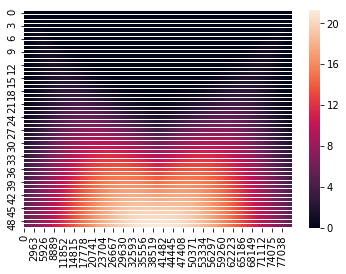

In [37]:
widths = np.linspace(1, 40000, 50)
cwtmatr = signal.cwt(rawPosSeries['y_tip'], signal.ricker, widths)
sns.heatmap(np.square(cwtmatr))

# Tensorflow model

In [72]:
from sklearn.utils import class_weight
input_dimension = X_train.shape[1]
weights = class_weight.compute_class_weight('balanced', 
                                            np.unique(y_train),
                                           y_train)

print(weights)

[0.60720863 2.83190176]


In [139]:
tf_model = tf.keras.Sequential()
tf_model.add(layers.Dense(10, activation='relu', input_dim = input_dimension))
tf_model.add(layers.Dense(1, activation = 'sigmoid'))

def focal_loss(gamma=2, alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):#with tensorflow
            eps = 1e-12
            y_pred=K.clip(y_pred,eps,1.-eps)#improve the stability of the focal loss and see issues 1 for more information
            pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
            pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
            return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

tf_model.compile(loss=focal_loss(), optimizer = 'adam', metrics=['accuracy'])

In [140]:
tf_model.fit(X_train, y_train, epochs=3000, batch_size = len(X_train) // 10)

Epoch 1/3000
121987/121987 [==============================] - 0s 2us/sample - loss: 706.8637 - acc: 0.8039
Epoch 2/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 697.3311 - acc: 0.8168
Epoch 3/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 690.5402 - acc: 0.8199
Epoch 4/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 686.0385 - acc: 0.8209
Epoch 5/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 682.4483 - acc: 0.8211
Epoch 6/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 678.3540 - acc: 0.8209
Epoch 7/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 672.8861 - acc: 0.8199
Epoch 8/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 668.5469 - acc: 0.8183
Epoch 9/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 664.6251 - acc: 0.8171
Epoch 10/3000
121987/121987 [========

121987/121987 [==============================] - 0s 1us/sample - loss: 521.6270 - acc: 0.8530
Epoch 77/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 520.1560 - acc: 0.8531
Epoch 78/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 518.7504 - acc: 0.8538
Epoch 79/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 517.2785 - acc: 0.8542
Epoch 80/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 515.8560 - acc: 0.8542
Epoch 81/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 514.3806 - acc: 0.8546
Epoch 82/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 512.9347 - acc: 0.8553
Epoch 83/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 511.4931 - acc: 0.8554
Epoch 84/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 510.0889 - acc: 0.8559
Epoch 85/3000
121987/121987 [=============

121987/121987 [==============================] - 0s 1us/sample - loss: 416.5613 - acc: 0.8817
Epoch 152/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 415.3707 - acc: 0.8823
Epoch 153/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 414.1026 - acc: 0.8824
Epoch 154/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 412.8681 - acc: 0.8829
Epoch 155/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 411.6657 - acc: 0.8833
Epoch 156/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 410.4620 - acc: 0.8832
Epoch 157/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 409.2341 - acc: 0.8839
Epoch 158/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 408.0175 - acc: 0.8842
Epoch 159/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 406.7531 - acc: 0.8845
Epoch 160/3000
121987/121987 [====

121987/121987 [==============================] - 0s 1us/sample - loss: 336.3833 - acc: 0.9013
Epoch 226/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 335.4540 - acc: 0.9023
Epoch 227/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 334.5791 - acc: 0.9018
Epoch 228/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 333.5645 - acc: 0.9024
Epoch 229/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 332.6734 - acc: 0.9025
Epoch 230/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 331.7560 - acc: 0.9025
Epoch 231/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 330.8664 - acc: 0.9028
Epoch 232/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 329.9319 - acc: 0.9029
Epoch 233/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 329.0544 - acc: 0.9029
Epoch 234/3000
121987/121987 [====

121987/121987 [==============================] - 0s 1us/sample - loss: 279.9156 - acc: 0.9126
Epoch 300/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 279.2205 - acc: 0.9133
Epoch 301/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 278.5131 - acc: 0.9133
Epoch 302/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 277.9737 - acc: 0.9134
Epoch 303/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 277.4212 - acc: 0.9132
Epoch 304/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 276.8450 - acc: 0.9138
Epoch 305/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 276.3130 - acc: 0.9132
Epoch 306/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 275.9705 - acc: 0.9135
Epoch 307/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 275.1872 - acc: 0.9138
Epoch 308/3000
121987/121987 [====

121987/121987 [==============================] - 0s 1us/sample - loss: 245.2063 - acc: 0.9192
Epoch 375/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 244.7896 - acc: 0.9194
Epoch 376/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 244.4724 - acc: 0.9198
Epoch 377/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 244.1573 - acc: 0.9196
Epoch 378/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 243.8183 - acc: 0.9199
Epoch 379/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 243.5652 - acc: 0.9197
Epoch 380/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 243.1969 - acc: 0.9196
Epoch 381/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 242.8658 - acc: 0.9200
Epoch 382/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 242.5559 - acc: 0.9199
Epoch 383/3000
121987/121987 [====

121987/121987 [==============================] - 0s 1us/sample - loss: 225.5909 - acc: 0.9237
Epoch 449/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 225.3793 - acc: 0.9236
Epoch 450/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 225.0052 - acc: 0.9233
Epoch 451/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 224.7710 - acc: 0.9236
Epoch 452/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 224.5074 - acc: 0.9237
Epoch 453/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 224.3088 - acc: 0.9241
Epoch 454/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 224.1167 - acc: 0.9238
Epoch 455/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 223.8741 - acc: 0.9240
Epoch 456/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 223.6353 - acc: 0.9240
Epoch 457/3000
121987/121987 [====

121987/121987 [==============================] - 0s 1us/sample - loss: 210.6828 - acc: 0.9275
Epoch 523/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 210.5222 - acc: 0.9276
Epoch 524/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 210.3413 - acc: 0.9278
Epoch 525/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 210.2441 - acc: 0.9278
Epoch 526/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 210.0419 - acc: 0.9278
Epoch 527/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 209.9159 - acc: 0.9278
Epoch 528/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 209.7354 - acc: 0.9280
Epoch 529/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 209.6841 - acc: 0.9280
Epoch 530/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 209.4565 - acc: 0.9278
Epoch 531/3000
121987/121987 [====

121987/121987 [==============================] - 0s 1us/sample - loss: 202.3690 - acc: 0.9297
Epoch 598/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 202.3337 - acc: 0.9296
Epoch 599/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 202.2308 - acc: 0.9298
Epoch 600/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 202.1466 - acc: 0.9299
Epoch 601/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 202.1587 - acc: 0.9297
Epoch 602/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 201.9838 - acc: 0.9298
Epoch 603/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 201.8379 - acc: 0.9295
Epoch 604/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 201.9162 - acc: 0.9298
Epoch 605/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 201.7365 - acc: 0.9299
Epoch 606/3000
121987/121987 [====

121987/121987 [==============================] - 0s 1us/sample - loss: 197.2380 - acc: 0.9314
Epoch 673/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 197.4097 - acc: 0.9310
Epoch 674/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 197.3253 - acc: 0.9309
Epoch 675/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 197.0102 - acc: 0.9311
Epoch 676/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 197.0288 - acc: 0.9311
Epoch 677/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 197.0179 - acc: 0.9314
Epoch 678/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 196.8535 - acc: 0.9316
Epoch 679/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 196.8512 - acc: 0.9314
Epoch 680/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 196.7820 - acc: 0.9314
Epoch 681/3000
121987/121987 [====

121987/121987 [==============================] - 0s 1us/sample - loss: 193.9853 - acc: 0.9323
Epoch 748/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 193.9603 - acc: 0.9319
Epoch 749/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 193.8381 - acc: 0.9326
Epoch 750/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 193.8051 - acc: 0.9325
Epoch 751/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 194.0210 - acc: 0.9323
Epoch 752/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 193.9200 - acc: 0.9322
Epoch 753/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 193.7745 - acc: 0.9322
Epoch 754/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 193.8447 - acc: 0.9319
Epoch 755/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 193.9679 - acc: 0.9323
Epoch 756/3000
121987/121987 [====

121987/121987 [==============================] - 0s 1us/sample - loss: 191.6481 - acc: 0.9327
Epoch 823/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 191.6377 - acc: 0.9327
Epoch 824/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 191.7123 - acc: 0.9329
Epoch 825/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 191.6391 - acc: 0.9331
Epoch 826/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 191.6869 - acc: 0.9329
Epoch 827/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 191.6639 - acc: 0.9330
Epoch 828/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 191.5179 - acc: 0.9326
Epoch 829/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 191.5465 - acc: 0.9330
Epoch 830/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 191.5317 - acc: 0.9327
Epoch 831/3000
121987/121987 [====

121987/121987 [==============================] - 0s 1us/sample - loss: 190.2097 - acc: 0.9332
Epoch 898/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 190.2007 - acc: 0.9338
Epoch 899/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 190.0121 - acc: 0.9337
Epoch 900/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 190.0017 - acc: 0.9334
Epoch 901/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 190.0329 - acc: 0.9334
Epoch 902/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 190.0168 - acc: 0.9334
Epoch 903/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 190.1173 - acc: 0.9334
Epoch 904/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 190.0550 - acc: 0.9336
Epoch 905/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 189.9830 - acc: 0.9335
Epoch 906/3000
121987/121987 [====

121987/121987 [==============================] - 0s 1us/sample - loss: 188.8874 - acc: 0.9341
Epoch 973/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 189.1537 - acc: 0.9343
Epoch 974/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 189.0258 - acc: 0.9337
Epoch 975/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 188.8575 - acc: 0.9334
Epoch 976/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 188.9523 - acc: 0.9343
Epoch 977/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 188.8909 - acc: 0.9346
Epoch 978/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 189.0232 - acc: 0.9335
Epoch 979/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 188.9414 - acc: 0.9341
Epoch 980/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 188.8958 - acc: 0.9339
Epoch 981/3000
121987/121987 [====

121987/121987 [==============================] - 0s 1us/sample - loss: 187.9328 - acc: 0.9350
Epoch 1047/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.9227 - acc: 0.9342
Epoch 1048/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.8711 - acc: 0.9344
Epoch 1049/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.8341 - acc: 0.9348
Epoch 1050/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.8587 - acc: 0.9346
Epoch 1051/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.9096 - acc: 0.9344
Epoch 1052/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.8223 - acc: 0.9342
Epoch 1053/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.8919 - acc: 0.9343
Epoch 1054/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.8726 - acc: 0.9345
Epoch 1055/3000
121987/121

121987/121987 [==============================] - 0s 1us/sample - loss: 187.0649 - acc: 0.9350
Epoch 1121/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.0267 - acc: 0.9350
Epoch 1122/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.0359 - acc: 0.9352
Epoch 1123/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.0296 - acc: 0.9349
Epoch 1124/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.0160 - acc: 0.9349
Epoch 1125/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 186.9887 - acc: 0.9351
Epoch 1126/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 186.9807 - acc: 0.9350
Epoch 1127/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.0725 - acc: 0.9350
Epoch 1128/3000
121987/121987 [==============================] - 0s 1us/sample - loss: 187.0646 - acc: 0.9351
Epoch 1129/3000
121987/121

KeyboardInterrupt: 

In [123]:
np.round(tf_model.predict(X_test))

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [74]:
# All features with transformation matrix
from sklearn.metrics import classification_report

print(classification_report(y_train, np.rint(tf_model.predict(X_train))))
print(classification_report(y_test, np.rint(tf_model.predict(X_test))))

              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93    100449
         1.0       0.76      0.48      0.59     21538

   micro avg       0.88      0.88      0.88    121987
   macro avg       0.83      0.72      0.76    121987
weighted avg       0.87      0.88      0.87    121987

              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93     25190
         1.0       0.75      0.46      0.57      5307

   micro avg       0.88      0.88      0.88     30497
   macro avg       0.82      0.71      0.75     30497
weighted avg       0.87      0.88      0.87     30497



In [141]:
# All features with transformation matrix (focal loss)
from sklearn.metrics import classification_report

print(classification_report(y_train, np.rint(tf_model.predict(X_train))))
print(classification_report(y_test, np.rint(tf_model.predict(X_test))))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96    100449
         1.0       0.75      0.94      0.84     21538

   micro avg       0.94      0.94      0.94    121987
   macro avg       0.87      0.94      0.90    121987
weighted avg       0.95      0.94      0.94    121987

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     25190
         1.0       0.75      0.94      0.83      5307

   micro avg       0.93      0.93      0.93     30497
   macro avg       0.87      0.94      0.90     30497
weighted avg       0.95      0.93      0.94     30497



In [136]:
labelTrace = go.Scatter(
    x = df_threeMarkersWithSpeed['timeStamp'][40000:50000],
    y = df_threeMarkersWithSpeed['label'][40000:50000],
    mode = 'markers',
    name = 'label'
)

predictedLabelTrace = go.Scatter(
    x = df_threeMarkersWithSpeed['timeStamp'][40000:50000],
    y =np.rint(tf_model.predict(df_threeMarkersWithSpeed[features][40000:50000])).flatten(),
    mode = 'markers',
    name = 'label'
)



data = [labelTrace, predictedLabelTrace]
fig = tools.make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.append_trace(labelTrace, 1, 1)
fig.append_trace(predictedLabelTrace, 2, 1)

py.offline.iplot(fig, filename = "tf_model")

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]



In [137]:
tf_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 10)                190       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 11        
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [142]:
# Save the weights
tf_model.save_weights('tf_NN_focal_clf_weights.h5')

# Save the model architecture
with open('tf_NN_focal_clf_architecture.json', 'w') as f:
    f.write(tf_model.to_json())